In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import h5py
import math
import matplotlib.pyplot as plt
import jax
import jax.numpy as np
import fk

## General simulations setup
This guarantees to have the same shape and samedx and dt

In [3]:
# simulation inputs (real values)
root = "/media/ep119/DATADRIVE3/epignatelli"
field_size = (12, 12)  # cm
d = 0.001  # (cm^2/ms)
cell_parameters = fk.params.params5()

# infinitesimals
dx = 0.01  # (cm/units) - Fenton 1998 recommends ~200, 300 micron/gridunit (~0.02, 0.03), smaller dx means finer grid
dt = 0.01  # (ms) - Fenton 1998 recommends few hundreds of ms (~0.01, 0.04)

# diffusivity 
d = 0.001  # cm^2/ms
shape = fk.convert.realsize_to_shape(field_size, dx)
diffusivity = np.ones(shape) * d

## Two linear waves

In [7]:
# times
start = 0  # ms
stop = 2000  # ms

# stimuli
protocol1 = fk.stimulus.protocol(start=0, duration=2)
s1 = fk.stimulus.triangular(shape, direction="left", angle=30, coverage=0.1, modulus=1., protocol=protocol1)

protocol2 = fk.stimulus.protocol(start=fk.convert.ms_to_units(400, dt), duration=2)
s2 = fk.stimulus.triangular(shape, direction="down", angle=40, coverage=0.6, modulus=1., protocol=protocol2)

stimuli = [s1, s2]

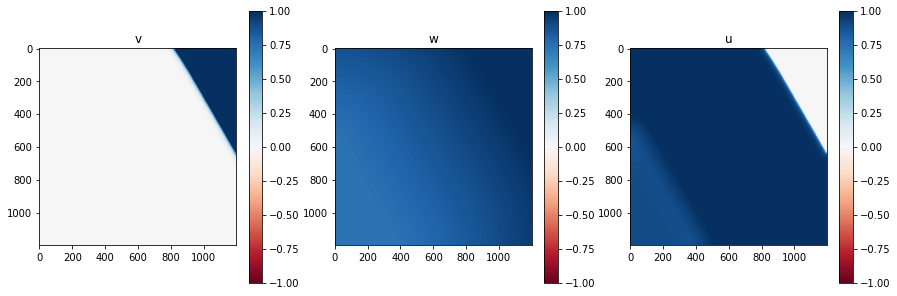

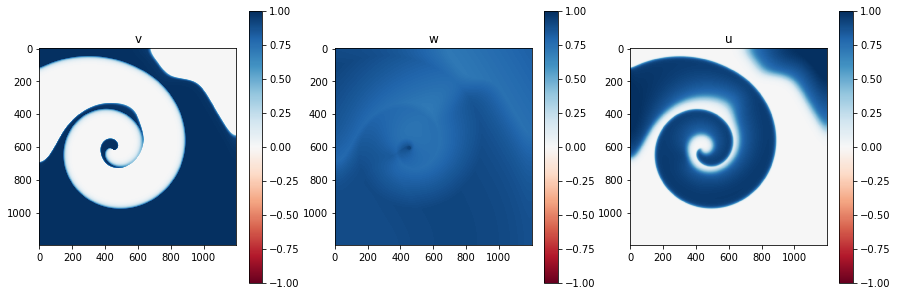

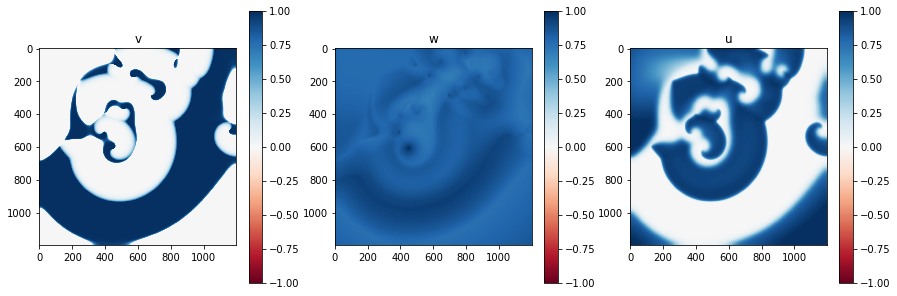

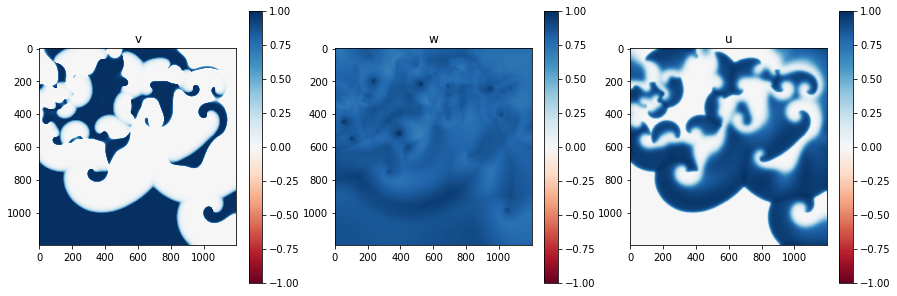

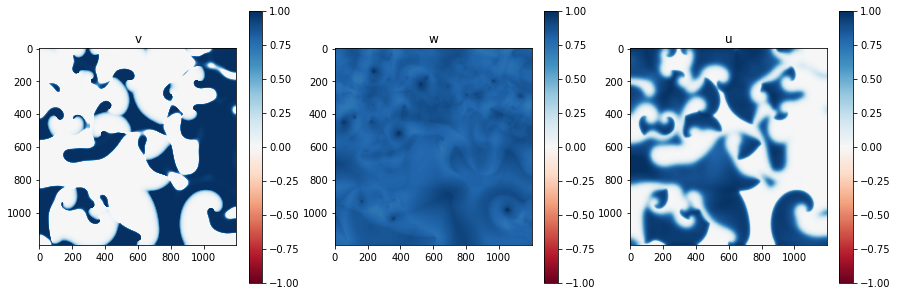

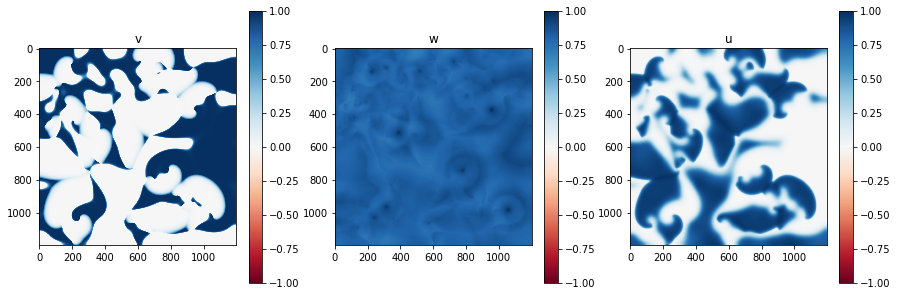

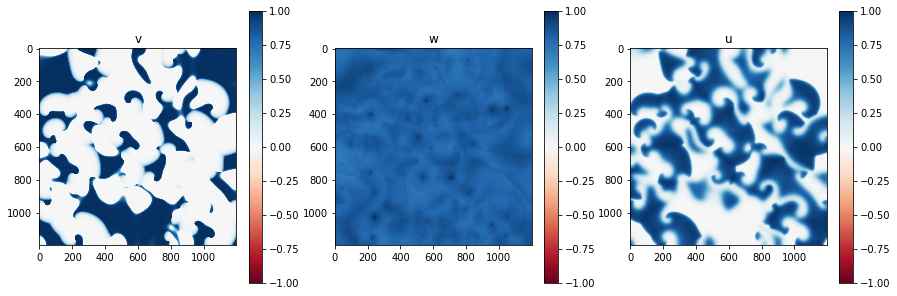

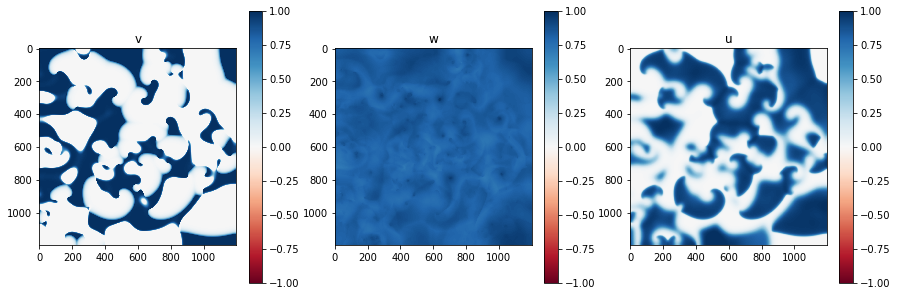

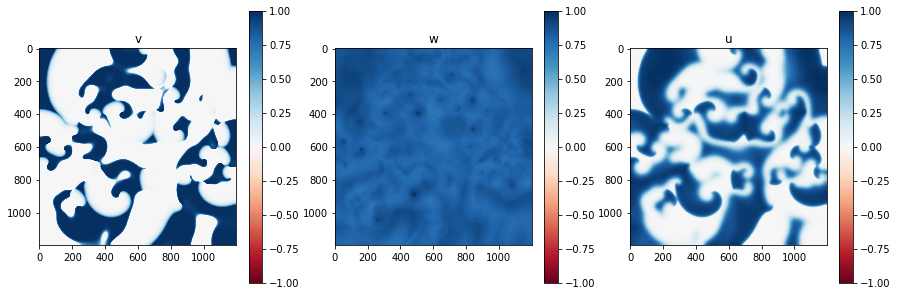

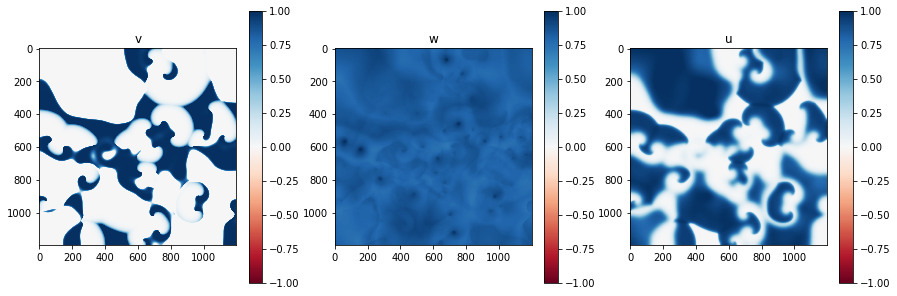

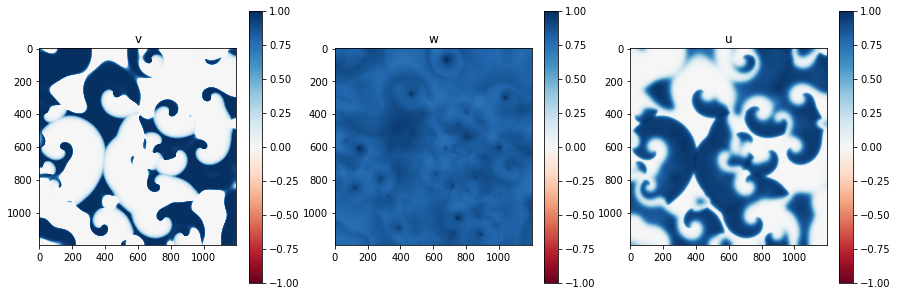

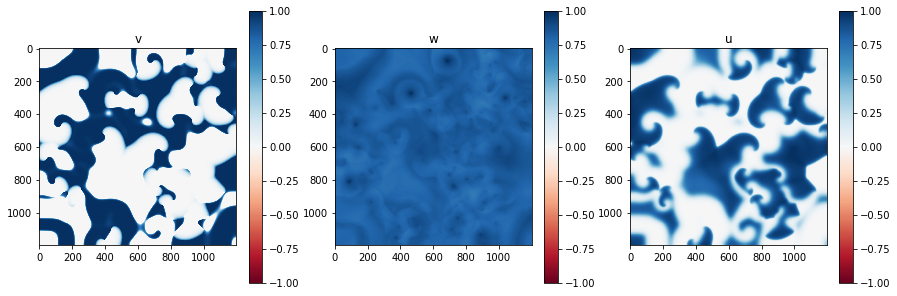

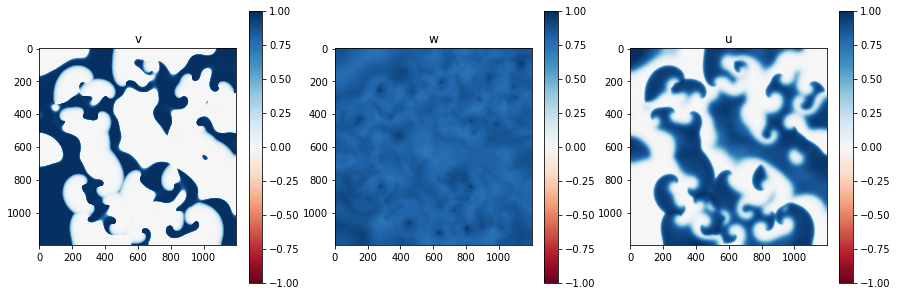

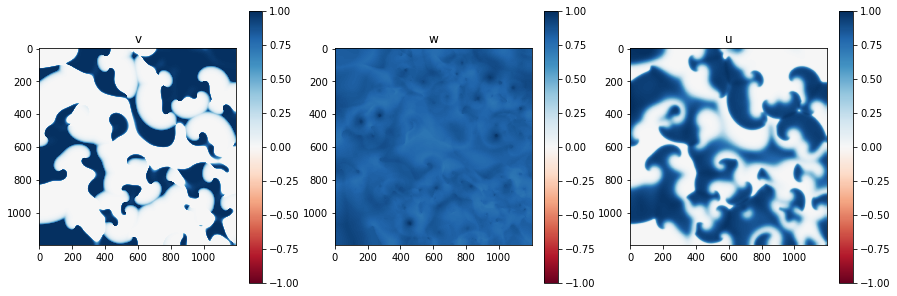

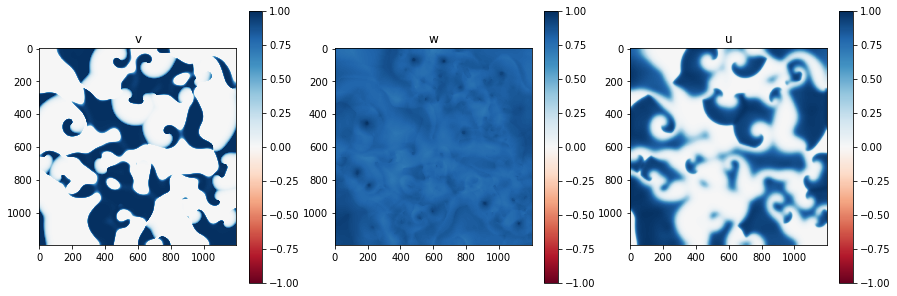

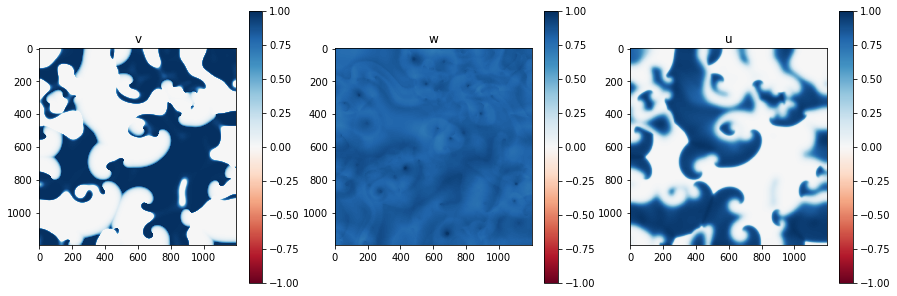

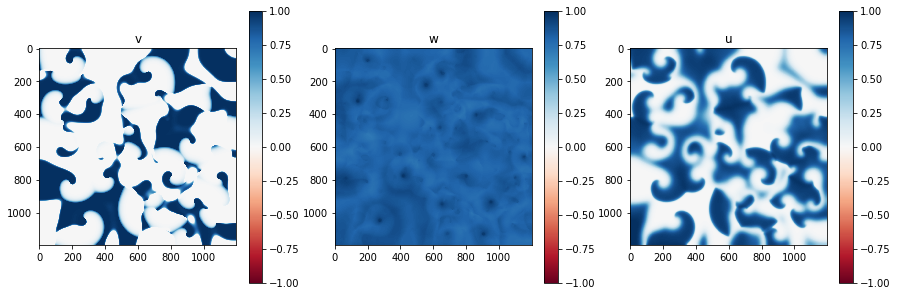

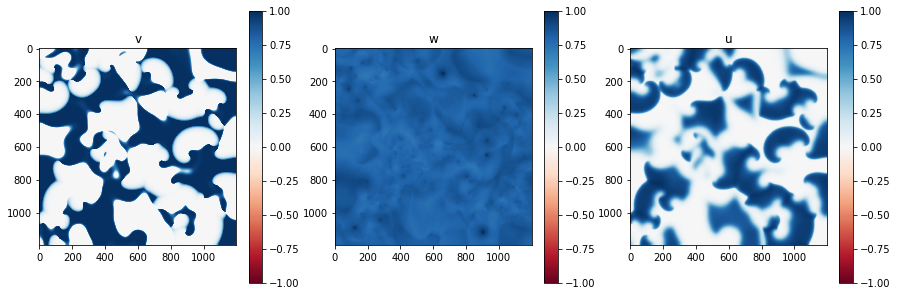

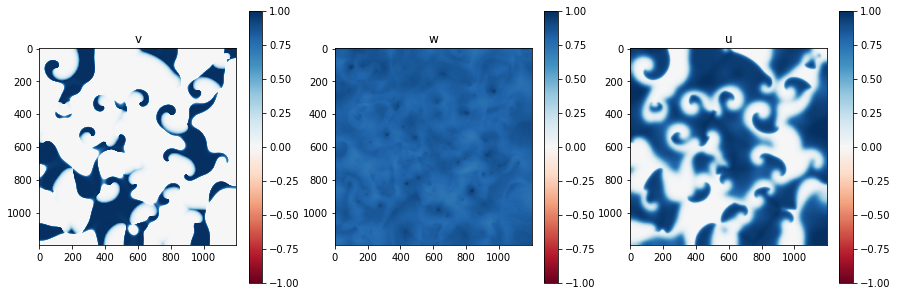

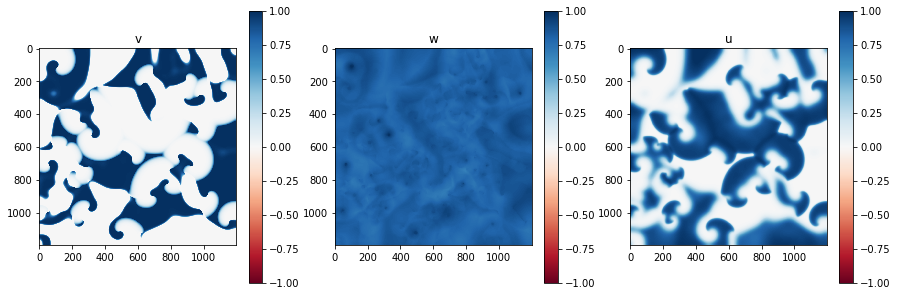

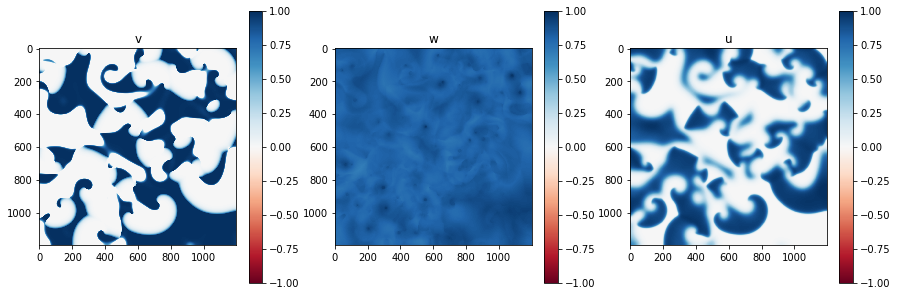

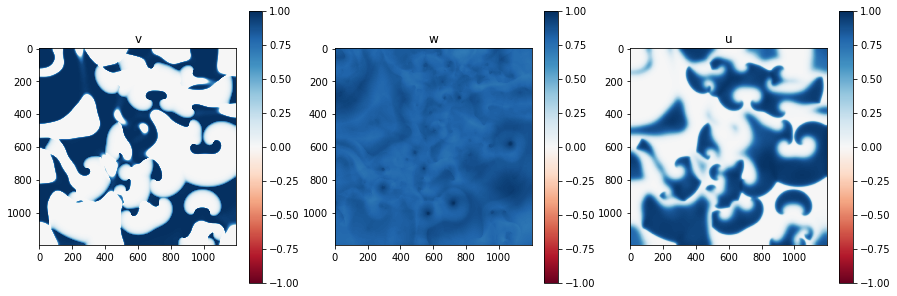

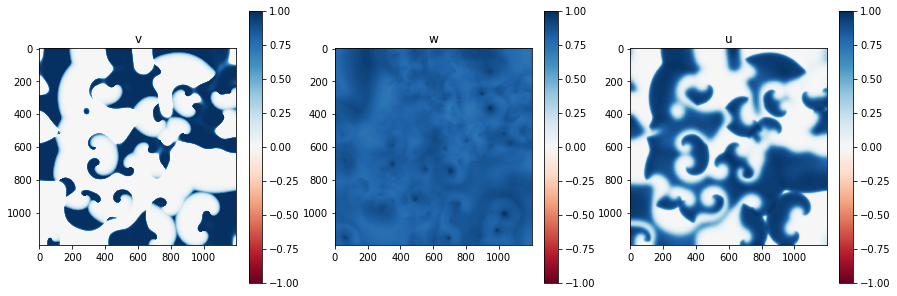

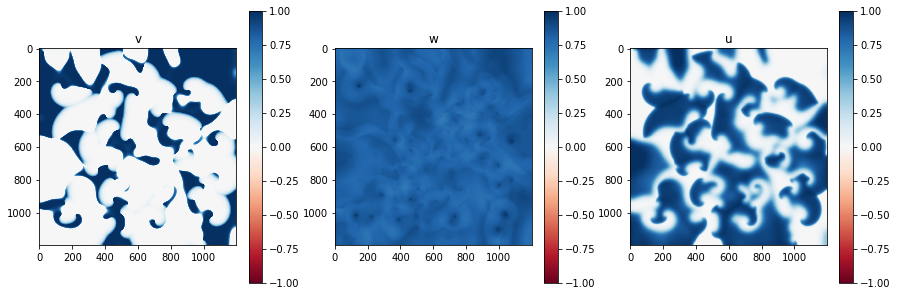

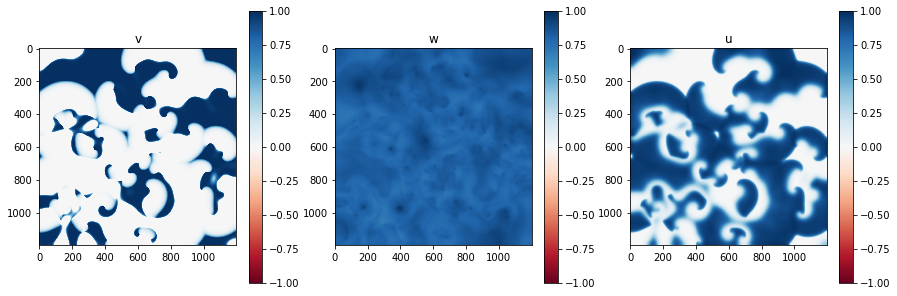

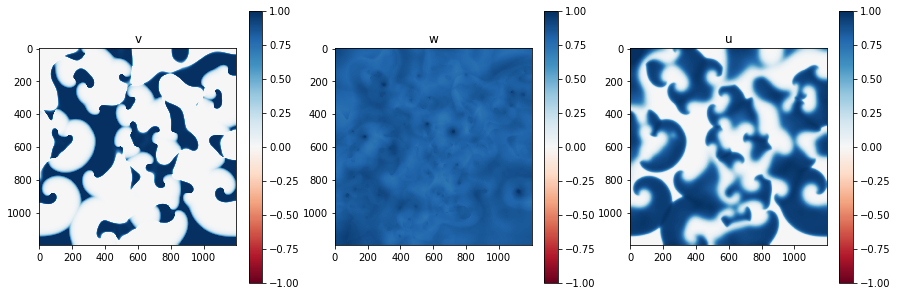

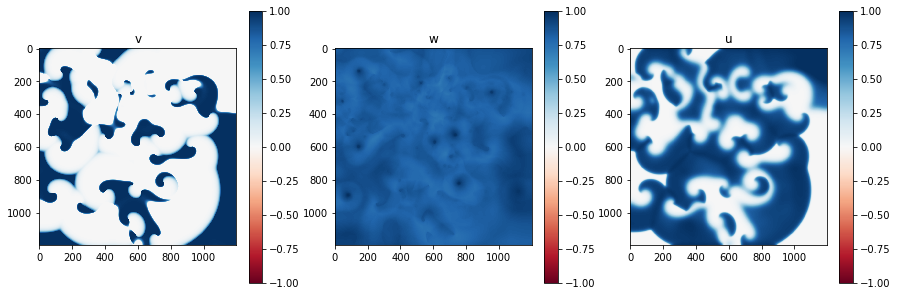

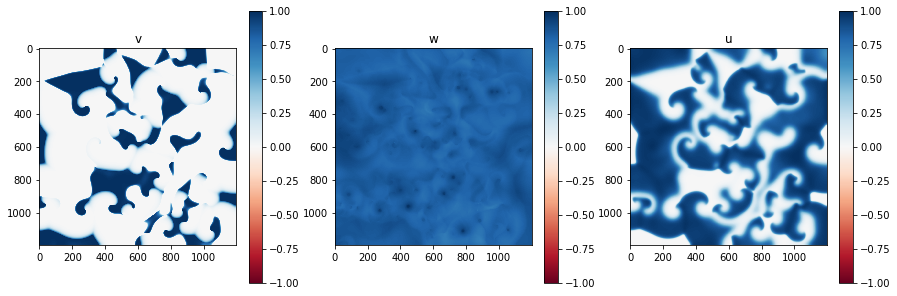

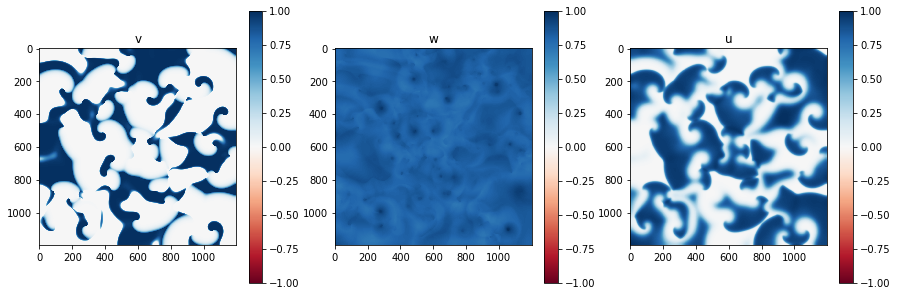

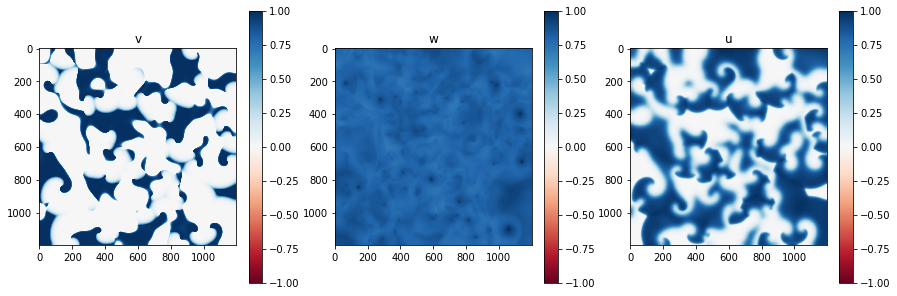

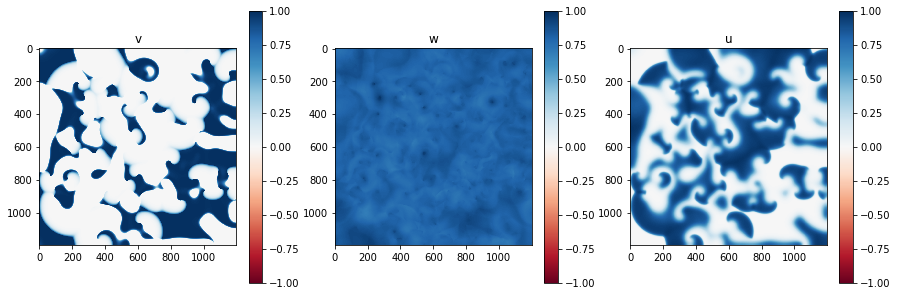

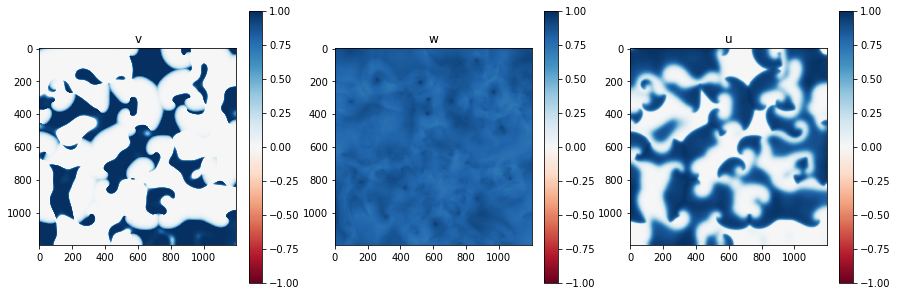

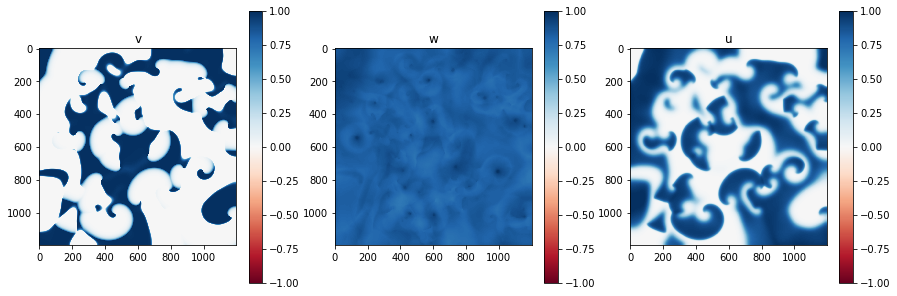

[DeviceArray([[1.2476777e+00, 1.2476796e+00, 1.2476759e+00, ...,
               5.1382107e-09, 5.1381974e-09, 5.1382023e-09],
              [1.2476797e+00, 1.2476816e+00, 1.2476771e+00, ...,
               5.1382076e-09, 5.1381934e-09, 5.1381988e-09],
              [1.2476529e+00, 1.2476541e+00, 1.2476504e+00, ...,
               5.1382170e-09, 5.1382050e-09, 5.1382094e-09],
              ...,
              [8.9764267e-01, 8.9764291e-01, 8.9764148e-01, ...,
               1.1338266e+00, 1.1338158e+00, 1.1338202e+00],
              [8.9764476e-01, 8.9764452e-01, 8.9764351e-01, ...,
               1.1338075e+00, 1.1337959e+00, 1.1338005e+00],
              [8.9764470e-01, 8.9764446e-01, 8.9764297e-01, ...,
               1.1338149e+00, 1.1338035e+00, 1.1338081e+00]],            dtype=float32),
 DeviceArray([[4.7535131e-09, 4.7559729e-09, 4.7495865e-09, ...,
               1.1341690e+00, 1.1340632e+00, 1.1341105e+00],
              [4.7593542e-09, 4.7618141e-09, 4.7550315e-09, ...,
      

In [8]:
checkpoints = np.arange(0, 1000000, 30000)
fk.model.forward(shape, checkpoints, cell_parameters, d, stimuli, dt, dx)

In [ ]:
fk.data.generate(start=fk.convert.ms_to_units(start, dt),
                 stop=fk.convert.ms_to_units(stop, dt),
                 dt=dt, dx=dx,
                 cell_parameters=cell_parameters,
                 diffusivity=diffusivity,
                 stimuli=stimuli,
                 filename="train_dev_set/spiral.hdf5")

In [ ]:
# display
show_every = 50  # ms
with h5py.File("train_dev_set/spiral.hdf5", "r") as file:
    states = file["states"][::show_every]
    print(file["states"].shape)
    print(states.shape)    

fig, ax = fk.plot.show_grid(states[:, 2], times=np.arange(0, len(states), 100), figsize=(25, 25))

## Three tailored stimuli

In [ ]:
# times
start = 0  # ms
stop = 2000  # ms

# stimuli
protocol1 = fk.stimulus.protocol(start=0, duration=2, period=0)
centre = fk.convert.realsize_to_shape((2, 2), dx)
size = fk.convert.realsize_to_shape((1, 1), dx)
s1 = fk.stimulus.rectangular(shape, centre, size, .8, protocol1)

protocol2 = fk.stimulus.protocol(start=fk.convert.ms_to_units(445, dt), duration=2, period=0)
centre = fk.convert.realsize_to_shape((5, 5), dx)
size = fk.convert.realsize_to_shape((1, 1), dx)
s2 = fk.stimulus.rectangular(shape, centre, size, .8, protocol2)

protocol3 = fk.stimulus.protocol(start=fk.convert.ms_to_units(495, dt), duration=2, period=0)
centre = fk.convert.realsize_to_shape((7.5, 2.5), dx)
size = fk.convert.realsize_to_shape((1, 1), dx)
s3 = fk.stimulus.rectangular(shape, centre, size, .8, protocol3)

stimuli = [s1, s2, s3]

In [ ]:
fk.data.generate(start=fk.convert.ms_to_units(start, dt),
                 stop=fk.convert.ms_to_units(stop, dt),
                 dt=dt, dx=dx,
                 cell_parameters=cell_parameters,
                 diffusivity=diffusivity,
                 stimuli=stimuli,
                 filename="train_dev_set/three_points.hdf5")

In [ ]:
# display
show_every = 100  # ms
with h5py.File("train_dev_set/three_points.hdf5", "r") as file:
    states = file["states"][::show_every]
    print(file["states"].shape)
    print(states.shape)    

fig, ax = fk.plot.show_grid(states[:, 2], figsize=(15, 15))

## Heartbeat + external

In [ ]:
# times
start = 0  # ms
stop = 2000  # ms

# stimuli
import random
heartbeat = fk.stimulus.protocol(start=0, duration=2, period=140)
heartbeat = fk.stimulus.random_triangular(shape, 1., protocol=heartbeat)

external = fk.stimulus.protocol(start=fk.convert.ms_to_units(450, dt), duration=2, period=fk.convert.ms_to_units(200, dt))
x1 = random.random() * (field_size[0] - 1)
x2 = random.random() * (field_size[1] - 1)
centre = fk.convert.realsize_to_shape((x1, x2), dx)
size = fk.convert.realsize_to_shape((1, 1), dx)
external = fk.stimulus.rectangular(shape, centre, size, 1., external)

stimuli = [heartbeat, external]

In [ ]:
fk.data.generate(start=fk.convert.ms_to_units(start, dt),
                 stop=fk.convert.ms_to_units(stop, dt),
                 dt=dt, dx=dx,
                 cell_parameters=cell_parameters,
                 diffusivity=diffusivity,
                 stimuli=stimuli,
                 filename="train_dev_set/heartbeat.hdf5")

In [ ]:
# display
show_every = 100  # ms
with h5py.File("train_dev_set/heartbeat.hdf5", "r") as file:
    states = file["states"][::show_every]
    print(file["states"].shape)
    print(states.shape)    

fig, ax = fk.plot.show_grid(states[:, 2], figsize=(15, 15))